In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


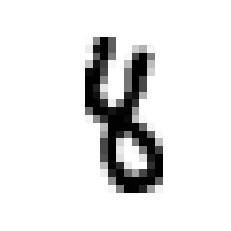

8


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[7000]
some_data_image = some_digit.reshape(28,28)

plt.imshow(some_data_image, cmap = mpl.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()
print(y[7000])

In [4]:
# y is in the form of a string, converting it to an integer,
import numpy as np
y = y.astype(np.uint8)

# To create a train and a test set,

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
# In this exercise, the first 60,000 instances (images) are used for training and the remaining 10,000 for testing.
# The data is already shuffled, which in this case, would ensure that all cross-validation being similar.

In [5]:
# Training a binary classifier,

# Trying instances containing 7 (Note: Binary would verify if an instance would or would not meet the condition)
y_train_7 = (y_train == 7)    # True for all 7s, False for all other instances
y_test_7 = (y_test == 7)

# Picking a classifier and training it,
from sklearn.linear_model import SGDClassifier    # Using the Stichastic Gradient Descent Classifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_7)

# Let's check the classifier by an instance,
sgd_clf.predict([some_digit])

array([False])

In [6]:
# Cross-validating the model with K-fold cross-validation technique,

from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_7, cv = 3, scoring = "accuracy")

array([0.98105, 0.9735 , 0.95335])

In [8]:
# Let's try a different model than SGD
# Let's try BaseEstimator

from sklearn.base import BaseEstimator

class Never7Classifier(BaseEstimator):
    def fit(self, X, y = None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

never_7_clf = Never7Classifier()
cross_val_score(never_7_clf, X_train, y_train_7, cv = 3, scoring = "accuracy")

array([0.89535, 0.8984 , 0.893  ])

In [9]:
# A much efficient way to check the accuracy is to compute the 'confusion matrix'.
# The general idea is to count the number of instance the class A was classified as class B

from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_7, cv = 3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_7, y_train_pred)

# The output contains a 2x2 array: The first row considers non-7 images (negative class), where the first element is
# the number of correctly classified instances (true negatives) and the second element as wrongly classified (false
# negatives). The second row consists of the first element as wrongly classfied 7s (false positives) and the second
# element consists of correctly classfied 7s (true positives).

array([[52581,  1154],
       [  688,  5577]], dtype=int64)

In [10]:
# While the confusion matrix would give the information required, a measure called 'precision' of a classifier can be
# derived from the confusion matrix. This accurately describes the positive predictions.

# A mathematical formula is precision = TP / (TP + FP), where TP - true positive, FP - false positive

# For further accuracy, another measure called 'recall' or 'sensitivity' or 'true positive rate' (TPR) is used along with
# the precision measure.

# recall = TP + (TP + FN), where TP - True Positive, FN - False Negative

# Computing precision and recall,
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_7, y_train_pred)
recall_score(y_train_7, y_train_pred)

0.8901835594573024

In [11]:
# It is often convenient to combine precision and recall into a single matrix called f1 score. The f1 score is the harmonic
# mean of precision and recall.
# Whilst the regular mean treats all values equally, a harmonic mean gives much more weight to low values.
# As a result, the classifier f1 will only get a hogh score if both precision and recall are high.

# The mathematical formula for f1 is:
# f1 = 2 / ( 1/precision + 1/recall) == TP/ (TP + ((FN + FP)/2))

# f1 is computed as,
from sklearn.metrics import f1_score
f1_score(y_train_7, y_train_pred)

0.8582640812557709

In [12]:
# With the type of the problem, it may be beneficial to increase or reduce precision or
# recall. As one increases, the other measure reduces - therefore, called the 
# precision/recall tradeoff.
# A score based on a decision function can be computed to make classification decisions
# If the score is greater than the threshold, it assigns the instance to the positive
# class, if not it's assigned to the negative class.

# Scikit-learn does not allow setting the threshold diectly, but it gives access to decision
# scores taken to make predictions.

y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = 0    # setting the threshold as zero for now. We increase this later on.
y_some_digit_pred = (y_scores > threshold)

[-14493.06965105]


In [13]:
# Now, let's try the threshold to be 8000
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


In [14]:
# To decide what threshold to use, it is important to get the scores of all instances in the
# training set using croos_val_predict() function, however, specifying to return by the method
# 'decision_function' instead
y_scores = cross_val_predict(sgd_clf, X_train, y_train_7, cv = 3, method = 'decision_function')

In [15]:
# With these scores, computing the precision/recall curve, we get,
from sklearn.metrics import precision_recall_curve
precisions, recall, thresholds = precision_recall_curve(y_train_7, y_scores)

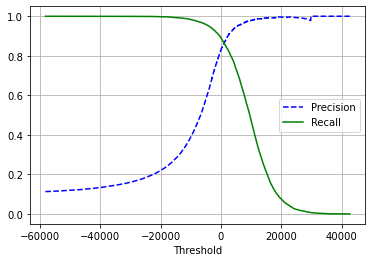

In [16]:
def plot_precision_recall_vs_thresholds (precisions, recall, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recall[:-1], "g-", label = "Recall")
    plt.xlabel("Threshold")
    plt.legend()
    plt.grid()
      

plot_precision_recall_vs_thresholds(precisions, recall, thresholds)
plt.show()

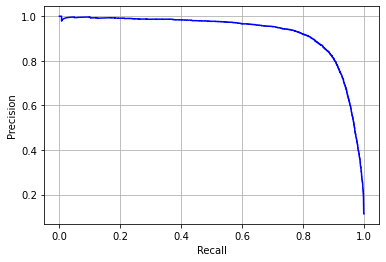

In [17]:
# Another way to measure the trade-off is to plot the precision vs. recall graph
plt.plot(recall[:-1], precisions[:-1], 'b-')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()

In [18]:
# Another common tool used with binary classifiers is the ROC (Receiver Operating Characteristic) curve
# Instead of precision and recall, it plots true positive rate (tpr) and false positive rate (fpr)
# By math, fpr = 1 - tnr (true negative rate) -> also called specificity.
# Therefore, the ROC curve plots sensitivity (recall) vs. (1 - specificity)

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_7, y_scores)

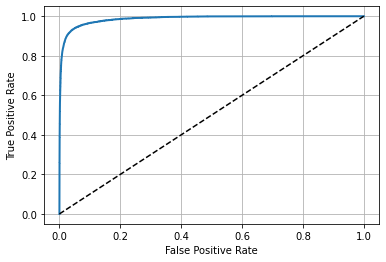

In [19]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0,1], [0,1], 'k--') # dashed diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid()
    
plot_roc_curve(fpr, tpr)
plt.show()

# The dotted line represents the ROC curve of a purely random classifier. A good classifier stays
# as far away from the line as possible.

In [20]:
# To compare classifiers, area under curve (AUC) could be calculated. A perfect classifier will
# have a ROC AUC of 1, whereas a purely random classifier will have a ROC AUC of 0.5.

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_7, y_scores)

0.986670497551944

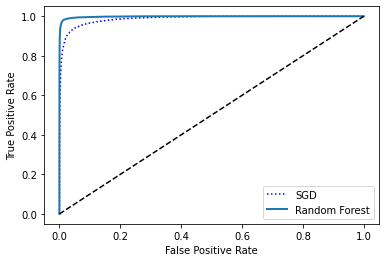

In [21]:
# Using random forest method to check the ROC AUC in comparison to SGD,
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_7, cv = 3,
                                 method = "predict_proba") # As there is no decision_function in
                                                           # Random Forest Classifier
y_scores_forest = y_probas_forest[:,1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_7, y_scores_forest)

# Plotting the graphs,
plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc = "lower right")
plt.grid()
plt.show()

In [22]:
# MULTICLASS OR MULTINOMIAL CLASSIFIERS

from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state = 42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])
len(ovo_clf.estimators_)

45

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = "accuracy")

In [ ]:
# Error analysis:
# Just as the data was prepared, algorithms short-listed, fine-tuning hyperparameters, and 
# automating. In this problem, it is assumed that a promising model is achieved, however, focussed
# on how these could be improved.

# Step 1 - Observe the confusion matrix
y_train_pred = cross_val_pred(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
# There are a lot of numbers, so an image representation may be easier for interpretation
plt.plot(conf_mx, cmap = plt.cm.gray)
plt.show()

# The plot shows light grey diagonal, therefore, indicating a fairly good classification.
# In some cases, if the diagonal values are fairly darker, these mean either there are fewer images
# of 7s or the classifier does not perform as well on 5 as on other digits.
# However, both could be the reason for the darker shade.

In [ ]:
# Checking on the error,
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()